In [114]:
#for array manipulations
import numpy as np
import pandas as pd
#for image processing
import cv2 
#for displaying images
import matplotlib.pyplot as plt
#to display images in this notebook, not in a separate window
%matplotlib inline
import seaborn as sns
#to access system resources such as directories
import os
#This wilallow us to get the training time of each model
import time
import glob
import random

In [120]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, auc, classification_report, confusion_matrix, recall_score,
            f1_score, precision_score, precision_recall_curve, precision_recall_fscore_support)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict 
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import VotingClassifier

from skimage.transform import rotate

In [3]:
#set our base directory. This should point to the location of the plant-diseases folder
base_dir = 'C:\\Users\\USER\\Documents\\GitHub\\maize-disease-detection'
#This is where our data is stored
data_folder = os.path.join(base_dir, 'data')
#Points to the folder containing the maize diseseases data
maize_data_folder = os.path.join(data_folder, 'maize')
#Contains our test data in different folders
test_data_folder = os.path.join(data_folder, 'test')
#this will contain our models and other model related data
models_dir = os.path.join(base_dir,'models')

In [113]:
#This function loads 32 images of a particular disease
def get_test_images(disease):
    '''
    disease:
        A string that could be common_rust, healthy, leaf_spot, nothern_leaf_blight
    ........
    disease_images:
        A list of images for the selected disease
    '''
    #this list will contain the 20 images returned
    disease_images = []
    #path to the images
    disease_images_path = os.path.join(test_data_folder, disease)
    for image_path in os.listdir(disease_images_path)[:30]:
        image_path = os.path.join(disease_images_path, image_path)
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        disease_images.append(image)
    return disease_images


#This function will help us plot 5 images
def plot_images(images, title):
    '''
    images: List
        List of images
    title: String
        Title for each image i.e name of disease
    '''
    plt.figure(figsize=(15,6))
    for i in range(len(images)):
        plt.subplot(1,len(images), i+1)
        plt.imshow(images[i])
        plt.title(title)
        plt.xticks([])
        plt.yticks([])
    plt.show()
    

#This function will help us plot 5 images
def plot_predictions(images, title):
    '''
    images: List
        List of images
    title: String
        Title for each image i.e name of disease
    '''
    plt.figure(figsize=(15,6))
    for i in range(len(images)):
        plt.subplot(1,len(images), i+1)
        plt.imshow(images[i])
        plt.title(title[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    

def extract_features_hog(image, feature_size=4096):
    hog = cv2.HOGDescriptor()
    features = hog.compute(image)
    required_features = features[:feature_size].ravel()
    return required_features

def extract_features():
    features = []
    labels = []
    diasese_names = ['common_rust', 'healthy', 'leaf_spot', 'nothern_leaf_blight']
    for i, folder in enumerate(diasese_names):
        folder_path = os.path.join(maize_data_folder, diasese_names[i])
        image_paths = glob.glob(folder_path+'/*.jpg')
        for image_path in image_paths[:300]:
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
            image_features = extract_features_hog(image)
            image_label = diasese_names[i]
            features.append(image_features)
            labels.append(image_label)
    features = np.array(features)
    labels = np.array(labels)
    features = StandardScaler().fit_transform(features)
    labels = LabelEncoder().fit_transform(labels)
    #X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3)
    
    return  features, labels

def extract_test_features():
    test_features = []
    test_labels = []
    diasese_names = ['common_rust', 'healthy', 'leaf_spot', 'nothern_leaf_blight']
    for i, folder in enumerate(diasese_names):
        folder_path = os.path.join(test_data_folder, diasese_names[i])
        image_paths = glob.glob(folder_path+'/*.jpg')
        for image_path in image_paths[:30]:
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
            image_features = extract_features_hog(image)
            image_label = diasese_names[i]
            test_features.append(image_features)
            test_labels.append(image_label)
    test_features = np.array(test_features)
    test_labels = np.array(test_labels)
    test_features = StandardScaler().fit_transform(test_features)
    test_labels = LabelEncoder().fit_transform(test_labels)
    #X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3)
    
    return  test_features, test_labels

#This method trains a modelon the new features
def train_model(model, features, labels):
    start = time.time()
    scores = cross_val_score(model, features, labels, scoring='accuracy', cv=10)
    stop = time.time()
    t = (stop - start)/10
    return round(scores.mean(), 2), round(t, 4)

def test_model(model, features, labels):
    predictions = cross_val_predict(model, features, labels, cv=10)
    accuracy = accuracy_score(predictions, labels)
    return round(accuracy, 2)

In [89]:
#The Random Forest classifier after hyperparameter tuning
hog_random_forest = RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features=100,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
#The Logistic Regression classifier after hyperparameter tuning
hog_logistic_regression = LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.1, verbose=0,
                   warm_start=False)
#The K-Nearest Neighbors classifier after hyperparameter tuning
hog_knearest_neighbors = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=1,
                     weights='distance')
#The Linear Support Vector classifier after hyperparameter tuning
hog_linear_svc = LinearSVC(C=0.0001, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.01,
          verbose=0)
#The Support Vector classifier after hyperparameter tuning
hog_svc = SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.1,
    verbose=False)

#A list of our models
hog_models = [
    hog_random_forest,
    hog_logistic_regression,
    hog_knearest_neighbors,
    hog_linear_svc,
    hog_svc
]

#A list of the names of our models
model_names = [
    'Random Forest',
    'Logistic Regression',
    'K-Nearest Neighbor',
    'Linear SVC',
    'Support Vector Classifier'
]

estimators = [
    ('Random Forest', hog_random_forest),
    ('Logistic Regression', hog_logistic_regression),
    ('K-Nearest Neighbor', hog_knearest_neighbors),
    ('Support Vector Classifier', hog_svc)
]

#SVC + Random Forest
svc_rf = [
    ('Random Forest', hog_random_forest),
    ('Support Vector Classifier', hog_svc)
]

#SVC + Logistic Regression
svc_lr = [
    ('Support Vector Classifier', hog_svc),
    ('Logistic Regression', hog_logistic_regression)
]

#Random Forest + Logistic Regression
rf_lr = [
    ('Random Forest', hog_random_forest),
    ('Logistic Regression', hog_logistic_regression)
]

voting_classifier = VotingClassifier(
    estimators=estimators,
    voting='soft'
)

svc_rf_voting_classifier = VotingClassifier(
    estimators=svc_rf,
    voting='soft'
)

svc_lr_voting_classifier = VotingClassifier(
    estimators=svc_lr,
    voting='soft'
)

rf_lr_voting_classifier = VotingClassifier(
    estimators=rf_lr,
    voting='soft'
)

In [ ]:
voting_classifier.fit(features, labels)
accuracy = voting_classifier.score(test_features, test_labels)
round(accuracy, 2)

In [15]:
#Here we generate features for training the modes
train_features, train_labels = extract_features()
train_features.shape, train_labels.shape

((1200, 4096), (1200,))

In [21]:
#Here we generate features for training the modes
test_features, test_labels = extract_test_features()
test_features.shape, test_labels.shape

((120, 4096), (120,))

In [17]:
#Random forest perfomance on train set
train_model(hog_random_forest, train_features, train_labels)

(0.78, 66.062)

In [22]:
#Random forest perfomance on test set
test_model(hog_random_forest, test_features, test_labels)

0.66

In [108]:
#The classification report
hog_random_forest.fit(train_features, train_labels)
predictions = hog_random_forest.predict(test_features)
encoder = LabelEncoder()
encoded_labels= encoder.fit_transform(['common_rust', 'healthy', 'leaf_spot', 
                                       'nothern_leaf_blight'])
decoded_predictions = encoder.inverse_transform(predictions)
decoded_test_labels = encoder.inverse_transform(test_labels)
print(classification_report(decoded_test_labels, decoded_predictions,  
                      labels=['common_rust', 'healthy', 'leaf_spot', 'nothern_leaf_blight']))

                     precision    recall  f1-score   support

        common_rust       0.90      0.87      0.88        30
            healthy       0.76      0.73      0.75        30
          leaf_spot       0.86      0.60      0.71        30
nothern_leaf_blight       0.56      0.77      0.65        30

           accuracy                           0.74       120
          macro avg       0.77      0.74      0.75       120
       weighted avg       0.77      0.74      0.75       120



In [18]:
#Logistic Regression perfomance on train set
train_model(hog_logistic_regression, train_features, train_labels)

(0.73, 1.8733)

In [23]:
#Logistic Regression perfomance on test set
test_model(hog_logistic_regression, test_features, test_labels)

0.56

In [106]:
#The classification report
hog_logistic_regression.fit(train_features, train_labels)
predictions = hog_logistic_regression.predict(test_features)
encoder = LabelEncoder()
encoded_labels= encoder.fit_transform(['common_rust', 'healthy', 'leaf_spot', 
                                       'nothern_leaf_blight'])
decoded_predictions = encoder.inverse_transform(predictions)
decoded_test_labels = encoder.inverse_transform(test_labels)
print(classification_report(decoded_test_labels, decoded_predictions,  
                      labels=['common_rust', 'healthy', 'leaf_spot', 'nothern_leaf_blight']))

                     precision    recall  f1-score   support

        common_rust       0.90      0.87      0.88        30
            healthy       0.66      0.63      0.64        30
          leaf_spot       0.66      0.63      0.64        30
nothern_leaf_blight       0.48      0.53      0.51        30

           accuracy                           0.67       120
          macro avg       0.67      0.67      0.67       120
       weighted avg       0.67      0.67      0.67       120



In [19]:
#SVC perfomance on train set
train_model(hog_svc, train_features, train_labels)

(0.73, 21.5886)

In [24]:
#SVC perfomance on test set
test_model(hog_svc, test_features, test_labels)

0.57

In [107]:
#The classification report
hog_svc.fit(train_features, train_labels)
predictions = hog_svc.predict(test_features)
encoder = LabelEncoder()
encoded_labels= encoder.fit_transform(['common_rust', 'healthy', 'leaf_spot', 
                                       'nothern_leaf_blight'])
decoded_predictions = encoder.inverse_transform(predictions)
decoded_test_labels = encoder.inverse_transform(test_labels)
print(classification_report(decoded_test_labels, decoded_predictions,  
                      labels=['common_rust', 'healthy', 'leaf_spot', 'nothern_leaf_blight']))

                     precision    recall  f1-score   support

        common_rust       0.87      0.87      0.87        30
            healthy       0.67      0.67      0.67        30
          leaf_spot       0.67      0.67      0.67        30
nothern_leaf_blight       0.53      0.53      0.53        30

           accuracy                           0.68       120
          macro avg       0.68      0.68      0.68       120
       weighted avg       0.68      0.68      0.68       120



In [91]:
voting_classifier.fit(train_features, train_labels)
accuracy = voting_classifier.score(test_features, test_labels)
round(accuracy, 2)

0.69

In [109]:
#The classification report
voting_classifier.fit(train_features, train_labels)
predictions = voting_classifier.predict(test_features)
encoder = LabelEncoder()
encoded_labels= encoder.fit_transform(['common_rust', 'healthy', 'leaf_spot', 
                                       'nothern_leaf_blight'])
decoded_predictions = encoder.inverse_transform(predictions)
decoded_test_labels = encoder.inverse_transform(test_labels)
print(classification_report(decoded_test_labels, decoded_predictions,  
                      labels=['common_rust', 'healthy', 'leaf_spot', 'nothern_leaf_blight']))

                     precision    recall  f1-score   support

        common_rust       0.90      0.87      0.88        30
            healthy       0.61      0.63      0.62        30
          leaf_spot       0.69      0.67      0.68        30
nothern_leaf_blight       0.58      0.60      0.59        30

           accuracy                           0.69       120
          macro avg       0.69      0.69      0.69       120
       weighted avg       0.69      0.69      0.69       120



In [92]:
svc_rf_voting_classifier.fit(train_features, train_labels)
accuracy = svc_rf_voting_classifier.score(test_features, test_labels)
round(accuracy, 2)

0.71

In [110]:
#The classification report
svc_rf_voting_classifier.fit(train_features, train_labels)
predictions = svc_rf_voting_classifier.predict(test_features)
encoder = LabelEncoder()
encoded_labels= encoder.fit_transform(['common_rust', 'healthy', 'leaf_spot', 
                                       'nothern_leaf_blight'])
decoded_predictions = encoder.inverse_transform(predictions)
decoded_test_labels = encoder.inverse_transform(test_labels)
print(classification_report(decoded_test_labels, decoded_predictions,  
                      labels=['common_rust', 'healthy', 'leaf_spot', 'nothern_leaf_blight']))

                     precision    recall  f1-score   support

        common_rust       0.84      0.90      0.87        30
            healthy       0.71      0.73      0.72        30
          leaf_spot       0.74      0.57      0.64        30
nothern_leaf_blight       0.56      0.63      0.59        30

           accuracy                           0.71       120
          macro avg       0.71      0.71      0.71       120
       weighted avg       0.71      0.71      0.71       120



In [93]:
svc_lr_voting_classifier.fit(train_features, train_labels)
accuracy = svc_lr_voting_classifier.score(test_features, test_labels)
round(accuracy, 2)

0.67

In [111]:
#The classification report
svc_lr_voting_classifier.fit(train_features, train_labels)
predictions = svc_lr_voting_classifier.predict(test_features)
encoder = LabelEncoder()
encoded_labels= encoder.fit_transform(['common_rust', 'healthy', 'leaf_spot', 
                                       'nothern_leaf_blight'])
decoded_predictions = encoder.inverse_transform(predictions)
decoded_test_labels = encoder.inverse_transform(test_labels)
print(classification_report(decoded_test_labels, decoded_predictions,  
                      labels=['common_rust', 'healthy', 'leaf_spot', 'nothern_leaf_blight']))

                     precision    recall  f1-score   support

        common_rust       0.90      0.87      0.88        30
            healthy       0.66      0.63      0.64        30
          leaf_spot       0.64      0.60      0.62        30
nothern_leaf_blight       0.50      0.57      0.53        30

           accuracy                           0.67       120
          macro avg       0.67      0.67      0.67       120
       weighted avg       0.67      0.67      0.67       120



In [94]:
rf_lr_voting_classifier.fit(train_features, train_labels)
accuracy = rf_lr_voting_classifier.score(test_features, test_labels)
round(accuracy, 2)

0.67

In [112]:
#The classification report
rf_lr_voting_classifier.fit(train_features, train_labels)
predictions = rf_lr_voting_classifier.predict(test_features)
encoder = LabelEncoder()
encoded_labels= encoder.fit_transform(['common_rust', 'healthy', 'leaf_spot', 
                                       'nothern_leaf_blight'])
decoded_predictions = encoder.inverse_transform(predictions)
decoded_test_labels = encoder.inverse_transform(test_labels)
print(classification_report(decoded_test_labels, decoded_predictions,  
                      labels=['common_rust', 'healthy', 'leaf_spot', 'nothern_leaf_blight']))

                     precision    recall  f1-score   support

        common_rust       0.87      0.87      0.87        30
            healthy       0.68      0.63      0.66        30
          leaf_spot       0.66      0.63      0.64        30
nothern_leaf_blight       0.48      0.53      0.51        30

           accuracy                           0.67       120
          macro avg       0.67      0.67      0.67       120
       weighted avg       0.67      0.67      0.67       120



In [8]:
#Here we load 30 images for each disease category, used for model testing
common_rust_test_images = get_test_images('common_rust')
healthy_test_images = get_test_images('healthy')
leaf_spot_test_images = get_test_images('leaf_spot')
nothern_leaf_blight_test_images = get_test_images('nothern_leaf_blight')

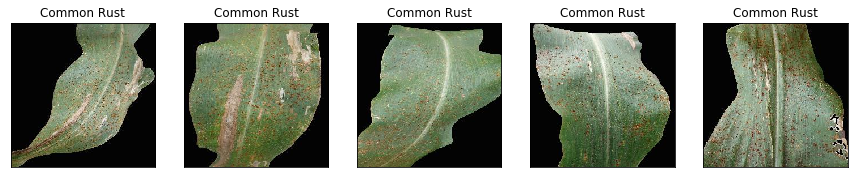

In [11]:
#Let us sample five images from common rust images
sample_common_rust = common_rust_test_images[:5]
#Display the five images
plot_images(sample_common_rust,'Common Rust')

In [78]:
#Generate features for the five images
cr_image_features = []
for image in sample_common_rust:
    hog_features = extract_features_hog(image)
    cr_image_features.append(hog_features)
cr_image_features = np.array(cr_image_features)
cr_image_features.shape

(5, 4096)

In [79]:
labels = ['common_rust', 'healthy', 'leaf_spot', 'nothern_leaf_blight']
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)
encoded_labels

array([0, 1, 2, 3], dtype=int64)

In [80]:
image_labels = ['common_rust']*5
image_labels

['common_rust', 'common_rust', 'common_rust', 'common_rust', 'common_rust']

In [ ]:
#We will try and see what each model predicts for the five common rust images

In [82]:
#Random forest
rf_predictions = hog_random_forest.predict(cr_image_features)
rf_predictions = encoder.inverse_transform(rf_predictions)
rf_predictions

array(['nothern_leaf_blight', 'nothern_leaf_blight',
       'nothern_leaf_blight', 'nothern_leaf_blight',
       'nothern_leaf_blight'], dtype='<U19')

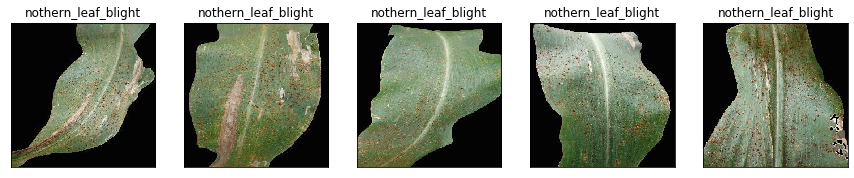

In [83]:
plot_predictions(sample_common_rust, rf_predictions)

In [84]:
#Logistic regression
lr_predictions = hog_logistic_regression.predict(cr_image_features)
lr_predictions = encoder.inverse_transform(lr_predictions)
lr_predictions

array(['common_rust', 'nothern_leaf_blight', 'nothern_leaf_blight',
       'nothern_leaf_blight', 'nothern_leaf_blight'], dtype='<U19')

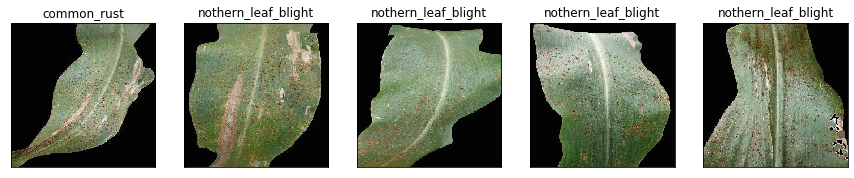

In [85]:
plot_predictions(sample_common_rust, lr_predictions)

In [86]:
#SVC
svc_predictions = hog_svc.predict(cr_image_features)
svc_predictions = encoder.inverse_transform(svc_predictions)
svc_predictions

array(['nothern_leaf_blight', 'nothern_leaf_blight',
       'nothern_leaf_blight', 'nothern_leaf_blight',
       'nothern_leaf_blight'], dtype='<U19')

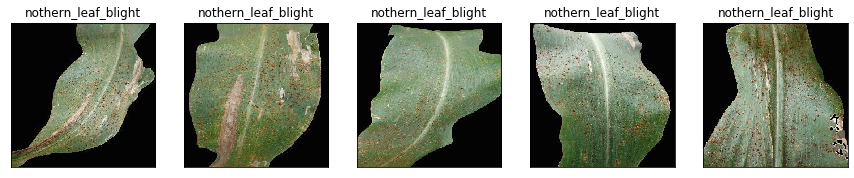

In [87]:
plot_predictions(sample_common_rust, svc_predictions)

In [95]:
voting_classifier_predictions = voting_classifier.predict(cr_image_features)
voting_classifier_predictions = encoder.inverse_transform(voting_classifier_predictions)
voting_classifier_predictions

array(['nothern_leaf_blight', 'nothern_leaf_blight',
       'nothern_leaf_blight', 'nothern_leaf_blight',
       'nothern_leaf_blight'], dtype='<U19')

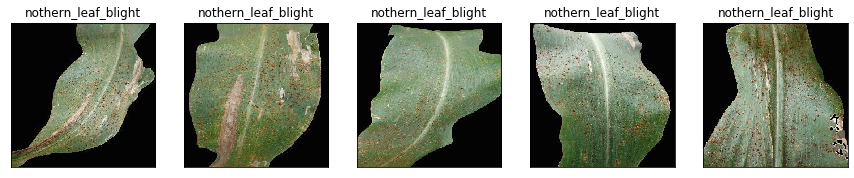

In [96]:
plot_predictions(sample_common_rust, voting_classifier_predictions)

In [98]:
svc_rf_voting_classifier_predictions = svc_rf_voting_classifier.predict(cr_image_features)
svc_rf_voting_classifier_predictions = encoder.inverse_transform(svc_rf_voting_classifier_predictions)
svc_rf_voting_classifier_predictions

array(['nothern_leaf_blight', 'nothern_leaf_blight',
       'nothern_leaf_blight', 'nothern_leaf_blight',
       'nothern_leaf_blight'], dtype='<U19')

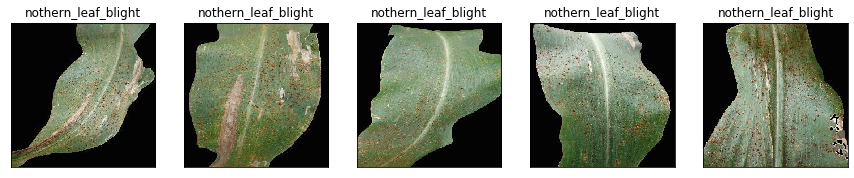

In [99]:
plot_predictions(sample_common_rust, svc_rf_voting_classifier_predictions)

In [100]:
svc_lr_voting_classifier_predictions = svc_lr_voting_classifier.predict(cr_image_features)
svc_lr_voting_classifier_predictions = encoder.inverse_transform(svc_lr_voting_classifier_predictions)
svc_lr_voting_classifier_predictions

array(['common_rust', 'nothern_leaf_blight', 'nothern_leaf_blight',
       'nothern_leaf_blight', 'nothern_leaf_blight'], dtype='<U19')

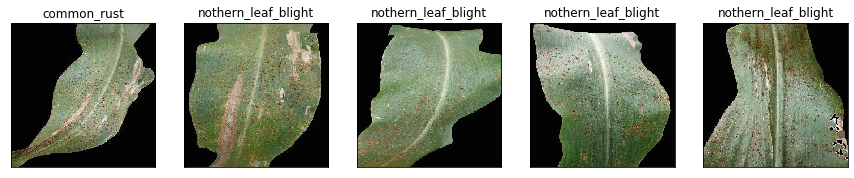

In [101]:
plot_predictions(sample_common_rust, svc_lr_voting_classifier_predictions)

In [102]:
rf_lr_voting_classifier_predictions = rf_lr_voting_classifier.predict(cr_image_features)
rf_lr_voting_classifier_predictions = encoder.inverse_transform(rf_lr_voting_classifier_predictions)
rf_lr_voting_classifier_predictions

array(['nothern_leaf_blight', 'nothern_leaf_blight',
       'nothern_leaf_blight', 'nothern_leaf_blight',
       'nothern_leaf_blight'], dtype='<U19')

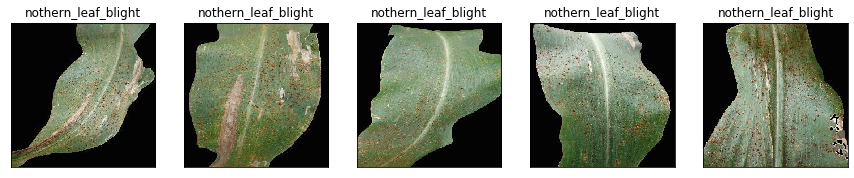

In [103]:
plot_predictions(sample_common_rust, rf_lr_voting_classifier_predictions)

In [134]:
#Let us do image augmentation
def augment_images():
    images = [] 
    rotation_choices = [45, 90, 180, 270, 360]
    #Let us randomly rotate the images
    for image in sample_common_rust:
        rotation = random.choice(rotation_choices)
        image = rotate(image, rotation)
        images.append(image)
    return images

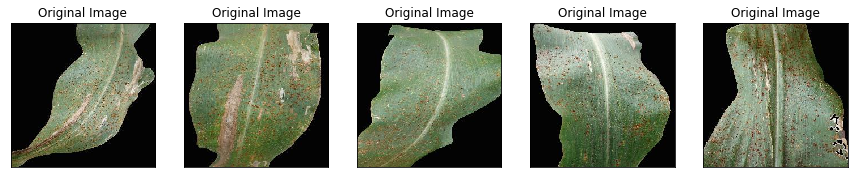

In [130]:
#Original images
plot_images(sample_common_rust, 'Original Image')

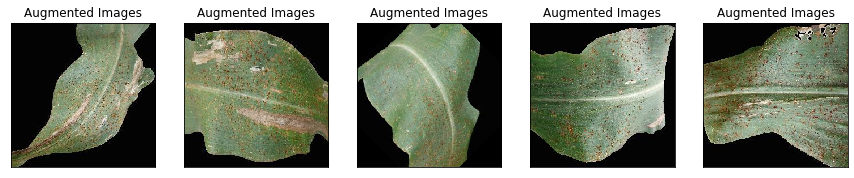

In [138]:
#Augmented images
images = augment_images()
plot_images(images, 'Augmented Images')

In [139]:
#Generate features for augmented immages
cr_image_features = []
for image in images:
    hog_features = extract_features_hog(image)
    cr_image_features.append(hog_features)
cr_image_features = np.array(cr_image_features)
cr_image_features.shape

error: OpenCV(4.2.0) C:\projects\opencv-python\opencv\modules\objdetect\src\hog.cpp:239: error: (-215:Assertion failed) img.type() == CV_8U || img.type() == CV_8UC3 in function 'cv::HOGDescriptor::computeGradient'


In [ ]:
#This is what I was telling you about; augmentation generates errors during feature extraction

In [ ]:
hog_models = [
    hog_random_forest,
    hog_logistic_regression,
    hog_knearest_neighbors,
    hog_linear_svc,
    hog_svc
]
#A list of the names of our models
model_names = [
    'Random Forest',
    'Logistic Regression',
    'K-Nearest Neighbor',
    'Linear SVC',
    'Support Vector Classifier'
]

estimators = [
    ('Random Forest', hog_random_forest),
    ('Logistic Regression', hog_logistic_regression),
    ('K-Nearest Neighbor', hog_knearest_neighbors),
    ('Support Vector Classifier', hog_svc)
]

svc_rf = [
    ('Random Forest', hog_random_forest),
    ('Support Vector Classifier', hog_svc)
]
svc_lr = [
    ('Support Vector Classifier', hog_svc),
    ('Logistic Regression', hog_logistic_regression)
]
rf_lr = [
    ('Random Forest', hog_random_forest),
    ('Logistic Regression', hog_logistic_regression)
]

voting_classifier = VotingClassifier(
    estimators=estimators,
    voting='soft'
)

svc_rf_voting_classifier = VotingClassifier(
    estimators=svc_rf,
    voting='soft'
)

svc_lr_voting_classifier = VotingClassifier(
    estimators=svc_lr,
    voting='soft'
)

rf_lr_voting_classifier = VotingClassifier(
    estimators=rf_lr,
    voting='soft'
)

In [142]:
models = [
    ('Random Forest', hog_random_forest),
    ('Logistic Regression', hog_logistic_regression),
    ('K-Nearest Neighbor', hog_knearest_neighbors),
    ('Linear SVC', hog_linear_svc),
    ('Support Vector Classifier', hog_svc),
    ('All Models', voting_classifier),
    ('SVC + Random Forest', svc_rf_voting_classifier),
    ('SVC + Logistic Regression', svc_lr_voting_classifier),
    ('Random Forest + Logistic Regression', rf_lr_voting_classifier)
]

In [168]:
def summary():
    model_name = []
    model_accuracy = []
    model_precision = []
    model_recall = []
    model_f1 = []
    for name, model in models:
        model.fit(train_features, train_labels)
        predictions = model.predict(test_features)
        
        accuracy = accuracy_score(predictions, test_labels)
        accuracy = round(accuracy, 2)
        
        precision = precision_score(test_labels, predictions, average='weighted')
        precision = round(precision, 2)
    
        recall = precision_score(test_labels, predictions, average='weighted')
        recall = round(recall, 2)
        
        f_score = f1_score(test_labels, predictions, average='weighted')
        f_score = round(f_score, 2)
        
        model_name.append(name)
        model_accuracy.append(accuracy)
        model_precision.append(precision)
        model_recall.append(recall)
        model_f1.append(f_score)
        
    df = pd.DataFrame(
        {
            'Model': model_name,
            'Accuracy': model_accuracy,
            'Precision': model_precision,
            'Recall': model_recall,
            'F1-Score': model_f1
        }
    )
    df = df.sort_values(by=['Accuracy', 'F1-Score'], ascending=False)
    return df

In [169]:
df = summary()
df

,Model,Accuracy,Precision,Recall,F1-Score
0,Random Forest,0.72,0.75,0.75,0.73
6,SVC + Random Forest,0.70,0.70,0.70,0.70
5,All Models,0.69,0.69,0.69,0.69
4,Support Vector Classifier,0.68,0.68,0.68,0.68
1,Logistic Regression,0.67,0.67,0.67,0.67
7,SVC + Logistic Regression,0.67,0.67,0.67,0.67
8,Random Forest + Logistic Regression,0.67,0.67,0.67,0.67
3,Linear SVC,0.66,0.66,0.66,0.66
2,K-Nearest Neighbor,0.62,0.63,0.63,0.62
